<a href="https://colab.research.google.com/github/RasyaAkbar/learning-py-torch/blob/main/05.%20Custom%20dataset%20%2B%20Exercise%20(L2%20%26%20dropout%20regularization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

In [ ]:
import torch
from torch import nn # nn contains all of building blocks of neural networks from torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn # great for machine learning purposes
# import torchvision
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

KeyboardInterrupt: 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # Images from 3 classes

# If the image folder doesn't exist, dowload it and unzip it
if image_path.is_dir():
  print(f"{image_path} already exist")
else:
  print("Creating directory...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # Create file with write permissions as f (shorthand for file)
  # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip") this will throw an error
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # make sure get the raw data, not blob
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: # Create file with read-only permission as f (shorthand for file)
  print(f"Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path) # Extract in image_path

## 2. Becoming one with the data (data preparation and data preparation)

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

In [ ]:
# Setup train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

### 2.1 Visualizing an image

1. Get all of the image paths
2. Pick a random image path using Python random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images,  let's open the image with Python PIL
5. Show the image and print meta data

In [ ]:
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

In [ ]:
len(image_path_list), image_path_list

In [ ]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

## 3. Transforming data

1. Turn target data into tensors
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`,

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)), # replicating size of image on cnn explainer website
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # 50% (0.5) of the time when it goes through this transform it will be flipped horizontally
    # Turn the image into a tensor
    transforms.ToTensor() # Turns (HWC) into (CHW) format
])

In [ ]:
data_transform(img)

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random Images from a path of images and loads/transforms them then
  plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax =plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f) # 0 axis show image
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image using matplotlib which uses (HWC) Format
      transformed_image = transform(f).permute(1, 2, 0) # Change shape (0, 1, 2) -> (1, 2, 0) whereas (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image\nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
)

## 4. Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolderr to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )

train_data, test_data

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

In [ ]:
len(train_data), len(test_data)

In [ ]:
train_data.samples[0]

In [ ]:
# Index on train data dataset to get single image and label
img, label = train_data[0][0], train_data[0][1]
label,type(label),img.shape,img.dtype, img

In [ ]:
class_names[label]

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
os.cpu_count()

In [ ]:
#Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=True # We want to prevent order and let the machine train on various type of data
                              )

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=False # When evaluating a model, generally its better to have a specific order or atleast its ok to have order for test purpose
                              )

train_dataloader, test_dataloader

In [ ]:
len(train_dataloader),len(test_dataloader)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader)) # get first batch
test_features_batch, test_labels_batch = next(iter(test_dataloader))
train_features_batch.shape, test_labels_batch , train_labels_batch.shape, test_features_batch.argmax(dim=1)

## 5. Option 2: Loading image data with a custom `Dataset`

1. Load images from file
2. Want to be able to get class names from the Dataset
3. Get classes as dictionary from the Dataset

Pros:

* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:

* Even though you could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.dataset.ImageFolder()
train_data.classes, train_data.class_to_idx

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory
2. Raise an error if class names are not found (something wrong with directory structure)
3. Turn the class names into a dict and a list and return them

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f" Target dir: {target_directory}")

# Get the class named from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

In [ ]:
list(os.scandir(target_directory))

In [ ]:
def find_classes(directory: str)-> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise na error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (directory where the data is stored)
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of target classes mapped to integer labels
4. Create a function to `load_images()`, this fuction will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform: None
               ):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # "*" means all items within that path
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load_images(), this fuction will open an image
  def load_image(self, index: int) -> Image.Image:
    """
    Opens an image via a path and returns it
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len()__ method to return the length of our dataset
  def __len__(self)->int:
    """
    Returns the total number of sample
    """
    return len(self.paths)

  # 6. Overwrite the __getitem()__ method to return a given sample when passed an index
  def __getitem__(self, index: int)->Tuple[torch.Tensor,int]:
    """
    Returns one sample of data, data and label (X, y)
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Tranform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X, y)
    else:
      return img, class_idx # return untransformed image, label(X, y)


In [ ]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # We're not changing data augmentation when we are testing, only in training
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
len(train_data),len(train_data_custom)

In [ ]:
train_data_custom.classes == train_data.classes

In [ ]:
train_data_custom.class_to_idx

### 5.3 Create a function to display random images

1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset ,
                          classes: List[int]=None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None
                          ):
  # 2. Adjust display if n is too high
  if n > 6:
    display_shape = False
    if n > 10:
      n=10
      print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # (CHW) -> (HWC)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)

In [ ]:
type(train_data)

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=11,
                      classes=class_names,
                      seed=42)

## 5.4 Turn Custom data into dataloader

In [ ]:
#Turn custom train and test datasets into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=True # We want to prevent order and let the machine train on various type of data
                              )

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=False # When evaluating a model, generally its better to have a specific order or atleast its ok to have order for test purpose
                              )

train_dataloader_custom, test_dataloader_custom

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape # (B, C, H, W), (B)

### 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data. (zooming, invert color, rotate, etc...)

In [ ]:
# Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31 # magnitude of augmentation, in the range of 0-n. lets say 10 mag means rotated 45 deg 20 mag means rotated 90 deg
                                  ),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # We're not changing data augmentation when we are testing, only in training
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

In [ ]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [ ]:
# 1. Load and transform data
train_data_simple = ImageFolderCustom(targ_dir=train_dir,
                                      transform=simple_transform)
test_data_simple = ImageFolderCustom(targ_dir=test_dir,
                                      transform=simple_transform)
len(train_data),len(train_data_simple)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=True # We want to prevent order and let the machine train on various type of data
                              )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                              batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=False # When evaluating a model, generally its better to have a specific order or atleast its ok to have order for test purpose
                              )

train_dataloader_simple, test_dataloader_simple

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int
               ):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ) # stride by default is the same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        # Create conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ) # stride by default is the same as kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*169, out_features=output_shape) # 7*7 = 49 which is the shape when the image compressed is flatten
    )
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) benefited from operator fusion which behind the scene speeds up how GPU perform computation cuz its 1 step
    # https://horace.io/brrr_intro.html



In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # shape of color channels which in our case is 1
                              hidden_units=10, # same shape cnn explainer use
                              output_shape=len(class_names)).to(device)
model_0

### 7.3 Try a forward pass on a single image to test the model

In [ ]:
# Putting dummy data to see the correct multiplier for hidden_units classifier
rand_tensor = torch.rand(32,3,64,64).to(device)
model_0(rand_tensor)

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # This is 1 batch, can modify it as much as u want

### 7.5 Creating Training and testing loop for our custom dataset

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device
               ):
  """Performs a training with model trying to learn on data_loader"""
  ### Training
  train_loss, train_acc = 0, 0
  # Put model into training model
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    #2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate train loss

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+= ((y_pred_class==y).sum().item()/len(y_pred)) * 100

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    #if(batch % 2 == 0):
    #  print(f"Looked at {batch * len(X)} samples out of {len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(dataloader) # Average loss per batch

  # Average accuracy per batch
  train_acc /= len(dataloader)

  print(f"\nTrain loss: {train_loss:.4f} , Train accuracy: {train_acc:.4f}% ")
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device
              ):
  """Performs a test with model trying to learn on data_loader"""
  ### Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred_logits = model(X_test)

      #2. Calculate loss
      loss = loss_fn(test_pred_logits, y_test)
      test_loss += loss # Accumulate test loss

      # Calculate accuracy metric
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc+= ((test_pred_labels==y_test).sum().item()/len(test_pred_logits)) * 100
      #test_pred_labels = test_pred_logits.argmax(dim=1) # another way of doing it (?) further testing required
      #test_acc+= ((test_pred_labels==y_test).sum().item()/len(test_pred_labels)) * 100

    # Average loss per batch
    test_loss /= len(dataloader)

    # Average accuracy per batch
    test_acc /= len(dataloader)

  print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}%\n")
  return test_loss, test_acc

In [ ]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None
                     ):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001
                            )
loss_fn, optimizer

### 7.6 Creating `train()` to combine `train_step()` and `test_step()`

In [ ]:
# Import tqdm for progress bar
# tqdm.auto recognize computer enviroment we use and give the best type progress bar, ex: jupyter notebook bar differ from python script
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            device: torch.device = device,
            epochs: int = 5
          ):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Create training and test loop
  for epoch in tqdm(range(epochs)): # the way tqdm works is to wrap our iterator in tqdm
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer)
    model.eval()
    test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn)

    # Update result dictionary
    train_loss = train_loss.detach()
    print(train_loss, train_acc, test_loss, test_acc)
    results["train_loss"].append(train_loss.cpu())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.cpu())
    results["test_acc"].append(test_acc)


  return results


In [ ]:
# import timer
from timeit import default_timer as timer

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start = timer()

# Set number of epoch
NUM_EPOCHS = 5

model_0_results = train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=NUM_EPOCHS
      )


train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=next(model_0.parameters()).device
                                            )

In [ ]:
model_0_results

### 7.8 Plot the loss curves of Model 0

A loss curve is a way of tracking your model's progress overtime

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  with torch.inference_mode():
    # Get the loss values of results dictionary
    print(results["train_loss"])
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of results dictionary
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
model_0_results.values()

In [ ]:
plot_loss_curves(model_0_results)

## 8. Model 1: TinyVGG with Data Augmentation

### 8.1 Create transform with data augmentation

In [ ]:
# Create a transform with TrivialAugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31 # magnitude of augmentation, in the range of 0-n. lets say 10 mag means rotated 45 deg 20 mag means rotated 90 deg
                                  ),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # We're not changing data augmentation when we are testing, only in training
    transforms.ToTensor()
])

### 9.2 Create train test `Dataset`'s and `DataLoader`'s with data augment

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=True # We want to prevent order and let the machine train on various type of data
                              )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                              batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=False # When evaluating a model, generally its better to have a specific order or atleast its ok to have order for test purpose
                              )

train_dataloader_augmented, test_dataloader_simple

## 8.3 Construct and train model 1

In [ ]:
# Create model_1 and send it to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_1

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001
                            )
loss_fn, optimizer

In [ ]:
# import timer
from timeit import default_timer as timer

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start = timer()

# Set number of epoch
NUM_EPOCHS = 5

model_1_results = train(model=model_1,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader_simple,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=NUM_EPOCHS
      )


train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=next(model_1.parameters()).device
                                            )

### 8.4 Plot the loss curves of model 1

In [ ]:
plot_loss_curves(model_1_results)

## 9. Compare model results

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [ ]:
import pandas as pd
with torch.inference_mode():
  model_0_df = pd.DataFrame(model_0_results)
  model_1_df = pd.DataFrame(model_1_results)
model_1_df

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()


## 10. Making prediction on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesnt exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f: # Create file with write permissions as f (shorthand for file)
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg") # make sure get the raw data, not blob
    print(f"Downloading Image...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist")

### 10.1 Loading in a custom Image with pytorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

custom_image_uint8.shape, custom_image_uint8.dtype, custom_image_uint8

In [ ]:
custom_image_uint8=custom_image_uint8.permute(1, 2, 0)

In [ ]:
plt.imshow(custom_image_uint8)
plt.axis(False)

### 10.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

In [ ]:
# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image, custom_image.shape

In [ ]:
plt.imshow(custom_image.permute(1,2,0))
plt.axis(False)

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

# Transform target image
custom_image_transformed =  custom_image_transform(custom_image)

custom_image_transformed.shape

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))
plt.axis(False)

In [ ]:
# this will error no batch size
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed.to(device))

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device)) # add 1 batch

custom_image_pred.argmax(dim=1), custom_image_pred

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
# Turn logits into prediction probabities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

# Turn prediction probabities into prediction label
custom_image_label=custom_image_pred_probs.argmax(dim=1)


plt.imshow(custom_image_transformed.permute(1,2,0))
plt.title(f"Prediction: {class_names[custom_image_label]} | Confidence: {custom_image_pred_probs.max()*100:.1f}%")
plt.axis(False)

In [ ]:
custom_image_pred_probs

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names:Dict[int, str],
                        transform: torchvision.transforms,
                        device: torch.device = device
                        ):
  # Read in custom image
  custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255

  # Transform target image
  custom_image_transformed = transform(custom_image)

  model.eval()
  with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device)) # add 1 batch

  # Turn logits into prediction probabities
  custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

  # Turn prediction probabities into prediction label
  custom_image_label=custom_image_pred_probs.argmax(dim=1)


  plt.imshow(custom_image_transformed.permute(1,2,0))
  plt.title(f"Prediction: {class_names[custom_image_label]} | Confidence: {custom_image_pred_probs.max()*100:.1f}%")
  plt.axis(False)


In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# Exercise (L2 and dropout)

In [ ]:
!pip3 install Cython

In [1]:
import torch
from torch import nn # nn contains all of building blocks of neural networks from torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn # great for machine learning purposes
# import torchvision
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [3]:
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  device = "cuda" if torch.cuda.is_available() else xm.xla_device()
except:
  device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # Images from 3 classes

# If the image folder doesn't exist, dowload it and unzip it
if image_path.is_dir():
  print(f"{image_path} already exist")
else:
  print("Creating directory...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # Create file with write permissions as f (shorthand for file)
  # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip") this will throw an error
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # make sure get the raw data, not blob
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: # Create file with read-only permission as f (shorthand for file)
  print(f"Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path) # Extract in image_path

Creating directory...
Unzipping pizza, steak, sushi data...


In [5]:
# Setup train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
# Create a transform with TrivialAugment
from torchvision import transforms
train_transform_ex = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=10  magnitude of augmentation, in the range of 0-n. lets say 10 mag means rotated 45 deg 20 mag means rotated 90 deg
                                  #),
    transforms.ToTensor()
])

test_transform_ex = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # We're not changing data augmentation when we are testing, only in training
    transforms.ToTensor()
])

In [7]:
# Use ImageFolderr to create dataset(s)
from torchvision import datasets
train_data_ex = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_ex, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )
test_data_ex = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform_ex, # transform for the data
                                  target_transform=None # transform for the label (we set it to none bcuz image directory is our label)
                                  )

train_data_ex, test_data_ex

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [8]:
import os
os.cpu_count()

2

In [9]:
#Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
train_dataloader_ex = DataLoader(dataset=train_data_ex,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=True # We want to prevent order and let the machine train on various type of data
                              )

test_dataloader_ex = DataLoader(dataset=test_data_ex,
                              batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(), # How many CPU cores that load the data (the higher the better)
                              shuffle=False # When evaluating a model, generally its better to have a specific order or atleast its ok to have order for test purpose
                              )

train_dataloader_ex, test_dataloader_ex

(<torch.utils.data.dataloader.DataLoader at 0x787cfbcd5000>,
 <torch.utils.data.dataloader.DataLoader at 0x787cfbcd4250>)

In [19]:
class TinyVGG2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int
               ):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=1 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=1 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ), # stride by default is the same as kernel size
        #nn.Dropout(p=0.5)#   Dropout with a 70% drop rate
    )

    self.conv_block_2 = nn.Sequential(
        # Create conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=1 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=1 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ), # stride by default is the same as kernel size
      #  nn.Dropout(p=0.5)   Dropout with a 55% drop rate
    )
    self.conv_block_3 = nn.Sequential(
        # Create conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # often also referred to as filter size, refers to the dimensions of the sliding window over the input. can be tuple, ex:(3, 3)
                  stride=1, # indicates how many pixels the kernel should be shifted over at a time.
                  padding=0 # By adding padding, the model retains information from the edges of the input data, which would otherwise be lost without padding.
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ), # stride by default is the same as kernel size
        nn.Dropout(p=0.5)  # Dropout with a 70% drop rate
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*676, out_features=output_shape) # 7*7 = 49 which is the shape when the image compressed is flatten
    )
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))) #benefited from operator fusion which behind the scene speeds up how GPU perform computation cuz its 1 step
    # https://horace.io/brrr_intro.html


In [20]:
#torch.manual_seed(42)
class_names = train_data_ex.classes
model_exc = TinyVGG2(input_shape=3, # shape of color channels which in our case is 1
                              hidden_units=10, # same shape cnn explainer use
                              output_shape=len(class_names)).to(device)
model_exc

TinyVGG2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace

In [21]:
model_exc(torch.rand(32,3,224,224).to(device))

tensor([[ 0.0041, -0.0404,  0.0324],
        [ 0.0144, -0.0166,  0.0431],
        [-0.0429,  0.0150, -0.0342],
        [ 0.0042, -0.0051,  0.0512],
        [-0.0246, -0.0584,  0.0823],
        [-0.0475,  0.0100,  0.0350],
        [-0.0352,  0.0296,  0.0398],
        [-0.0370, -0.0060,  0.0250],
        [-0.0242, -0.0087,  0.0387],
        [-0.0361, -0.0080,  0.0444],
        [ 0.0187, -0.0034,  0.0034],
        [-0.0373, -0.0793,  0.0267],
        [-0.0057, -0.0043,  0.0480],
        [-0.0079,  0.0225,  0.0358],
        [-0.0100,  0.0402,  0.0253],
        [-0.0155,  0.0647,  0.0436],
        [-0.0153, -0.0017,  0.0528],
        [-0.0492, -0.0266,  0.0485],
        [-0.0234, -0.0569,  0.0226],
        [-0.0382, -0.0160,  0.0958],
        [-0.0044,  0.0345,  0.0346],
        [-0.0618,  0.0247,  0.0633],
        [-0.0391, -0.0032,  0.0200],
        [-0.0595,  0.0050,  0.0137],
        [-0.0062, -0.0234,  0.0063],
        [-0.0276,  0.0025,  0.0454],
        [ 0.0181, -0.0224,  0.0110],
 

In [22]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device
               ):
  """Performs a training with model trying to learn on data_loader"""
  ### Training
  train_loss, train_acc = 0, 0
  # Put model into training model
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    l1_lambda = 0.001
    l1_norm = sum(p.abs().sum() for p in model.parameters())

    #2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate train loss

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+= ((y_pred_class==y).sum().item()/len(y_pred)) * 100

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    #if(batch % 2 == 0):
    #  print(f"Looked at {batch * len(X)} samples out of {len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(dataloader) # Average loss per batch

  # Average accuracy per batch
  train_acc /= len(dataloader)

  print(f"\nTrain loss: {train_loss:.4f} , Train accuracy: {train_acc:.4f}% ")
  return train_loss, train_acc

In [23]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device
              ):
  """Performs a test with model trying to learn on data_loader"""
  ### Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred_logits = model(X_test)

      #2. Calculate loss
      loss = loss_fn(test_pred_logits, y_test)
      test_loss += loss # Accumulate test loss

      # Calculate accuracy metric
      #test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      #test_acc+= ((test_pred_labels==y_test).sum().item()/len(test_pred_logits)) * 100
      test_pred_labels = test_pred_logits.argmax(dim=1) # another way of doing it (?) further testing required
      test_acc+= ((test_pred_labels==y_test).sum().item()/len(test_pred_labels)) * 100

    # Average loss per batch
    test_loss /= len(dataloader)

    # Average accuracy per batch
    test_acc /= len(dataloader)

  print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}%\n")
  return test_loss, test_acc

In [24]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None
                     ):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [25]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_exc.parameters(),
                            lr=0.001,
                            weight_decay=0.01
                            )
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.01
 ))

In [26]:
# Import tqdm for progress bar
# tqdm.auto recognize computer enviroment we use and give the best type progress bar, ex: jupyter notebook bar differ from python script
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            device: torch.device = device,
            epochs: int = 5
          ):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Create training and test loop
  for epoch in tqdm(range(epochs)): # the way tqdm works is to wrap our iterator in tqdm
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer)
    model.eval()
    test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn)

    # Update result dictionary
    train_loss = train_loss.detach()
    #print(train_loss, train_acc, test_loss, test_acc)
    results["train_loss"].append(train_loss.cpu())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.cpu())
    results["test_acc"].append(test_acc)


  return results


In [27]:
# import timer
from timeit import default_timer as timer

# Set the seed and start the timer
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)
train_time_start = timer()

# Set number of epoch
NUM_EPOCHS = 25

model_exc_results = train(model=model_exc,
      train_dataloader=train_dataloader_ex,
      test_dataloader=test_dataloader_ex,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=NUM_EPOCHS
      )


train_time_end = timer()
total_train_time_model_exc = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=next(model_exc.parameters()).device
                                            )

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
-----

Train loss: 1.1037 , Train accuracy: 37.1094% 
Test loss: 1.0999, Test accuracy: 26.0417%

Epoch: 1
-----

Train loss: 1.1494 , Train accuracy: 30.4688% 
Test loss: 1.1294, Test accuracy: 26.0417%

Epoch: 2
-----

Train loss: 1.1143 , Train accuracy: 30.4688% 
Test loss: 1.1241, Test accuracy: 19.7917%

Epoch: 3
-----

Train loss: 1.1157 , Train accuracy: 29.2969% 
Test loss: 1.0971, Test accuracy: 19.7917%

Epoch: 4
-----

Train loss: 1.1004 , Train accuracy: 22.2656% 
Test loss: 1.0922, Test accuracy: 54.1667%

Epoch: 5
-----

Train loss: 1.1021 , Train accuracy: 27.3438% 
Test loss: 1.0801, Test accuracy: 54.1667%

Epoch: 6
-----

Train loss: 1.0926 , Train accuracy: 37.5000% 
Test loss: 1.0944, Test accuracy: 26.0417%

Epoch: 7
-----

Train loss: 1.0827 , Train accuracy: 42.5781% 
Test loss: 1.1097, Test accuracy: 26.0417%

Epoch: 8
-----

Train loss: 1.1180 , Train accuracy: 30.4688% 
Test loss: 1.1239, Test accuracy: 26.0417%

Epoch: 9
-----

Train loss: 1.1069 , 

In [28]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  with torch.inference_mode():
    # Get the loss values of results dictionary
    print(results["train_loss"])
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of results dictionary
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

[tensor(1.1037), tensor(1.1494), tensor(1.1143), tensor(1.1157), tensor(1.1004), tensor(1.1021), tensor(1.0926), tensor(1.0827), tensor(1.1180), tensor(1.1069), tensor(1.0959), tensor(1.0944), tensor(1.0915), tensor(1.1083), tensor(1.0997), tensor(1.1113), tensor(1.0973), tensor(1.1018), tensor(1.0963), tensor(1.0995), tensor(1.0989), tensor(1.0984), tensor(1.0977), tensor(1.0970), tensor(1.1026)]


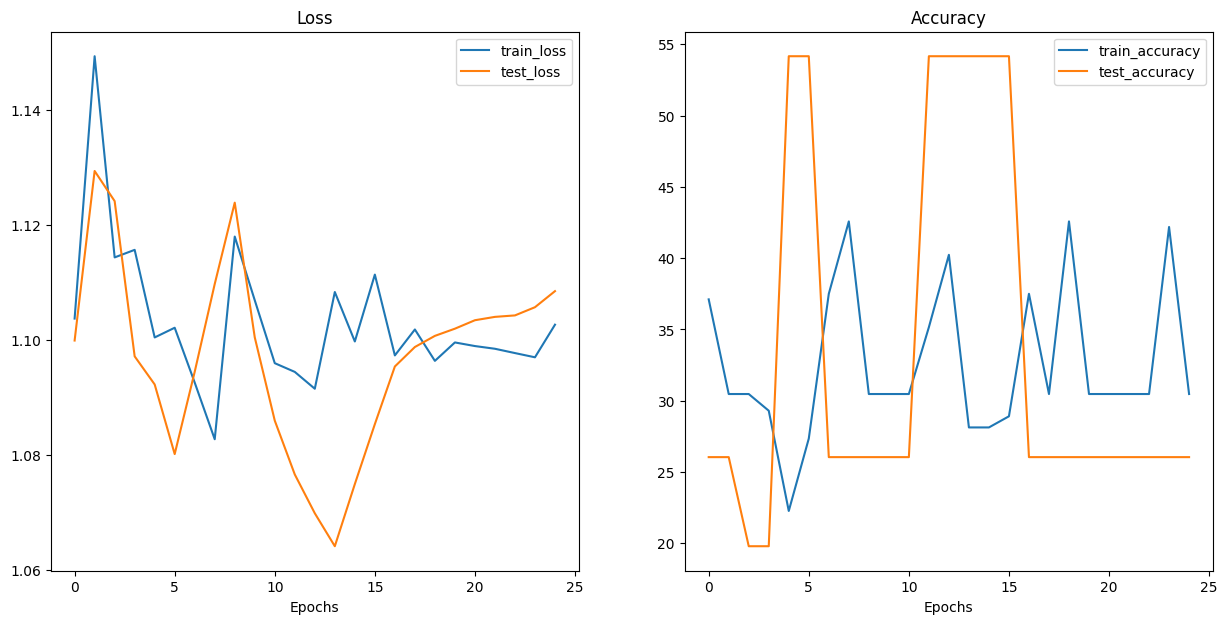

In [29]:
plot_loss_curves(model_exc_results)